In [4]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


In [6]:
#%% ✅ Load and Process Dataset
file_path = "combined_data_new.csv"  # Update with actual file path
df = pd.read_csv(file_path)


<ipython-input-7-8524c6946d43>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Label"], palette="pastel")


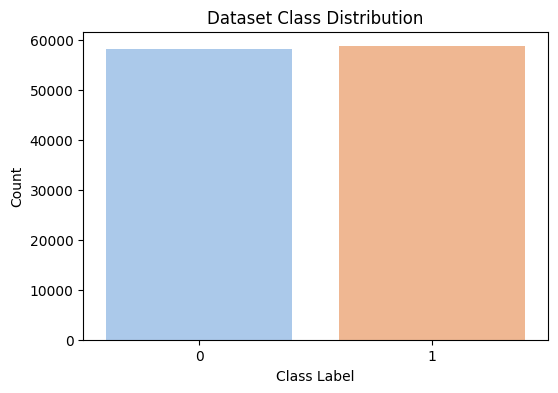

In [7]:
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Label"], palette="pastel")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Dataset Class Distribution")
plt.show()

In [9]:
# Split data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Ingredients'], df['Label'], test_size=0.2, random_state=42
)

#%% ✅ Load BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Convert Data to Hugging Face Dataset
train_dataset = Dataset.from_pandas(pd.DataFrame({"text": train_texts, "label": train_labels}))
test_dataset = Dataset.from_pandas(pd.DataFrame({"text": test_texts, "label": test_labels}))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
# Tokenization Function
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="longest", max_length=128)

# Apply Tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set Format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Define Data Collator for Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map:   0%|          | 0/93522 [00:00<?, ? examples/s]

Map:   0%|          | 0/23381 [00:00<?, ? examples/s]

In [11]:
#%% ✅ Load Pre-Trained BERT Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
#%% ✅ Define Optimized Training Arguments
training_args = TrainingArguments(
    output_dir="./bert_results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./bert_logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,  # ✅ Mixed Precision Training
    gradient_accumulation_steps=2,  # ✅ Helps with larger batch sizes on limited memory
    dataloader_num_workers=4,  # ✅ Multi-threaded Data Loading
    report_to="none",  # ✅ Avoids unnecessary logging
)

#%% ✅ Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train Model
trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-c9058ede575e>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.029800,0.019867
2,0.001000,0.014491
3,0.011300,0.016034
4,0.001000,0.013855


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

TrainOutput(global_step=11692, training_loss=0.022537628969026578, metrics={'train_runtime': 2879.027, 'train_samples_per_second': 129.936, 'train_steps_per_second': 4.061, 'total_flos': 2.460665670271452e+16, 'train_loss': 0.022537628969026578, 'epoch': 4.0})

In [13]:
#%% ✅ Evaluate Model
# Get Predictions
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Print Classification Report
print(classification_report(test_labels, predicted_labels, target_names=["Non-Cosmetic", "Cosmetic"]))


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

Non-Cosmetic       1.00      1.00      1.00     11556
    Cosmetic       1.00      1.00      1.00     11825

    accuracy                           1.00     23381
   macro avg       1.00      1.00      1.00     23381
weighted avg       1.00      1.00      1.00     23381



In [14]:
#%% ✅ Save Model & Tokenizer
def save_model():
    model.save_pretrained("fine_tuned_bert")
    tokenizer.save_pretrained("fine_tuned_bert")
    print("✅ Fine-tuned BERT model and tokenizer saved successfully!")

save_model()

✅ Fine-tuned BERT model and tokenizer saved successfully!


In [15]:
import shutil

# Zip the fine-tuned model directory
shutil.make_archive("fine_tuned_bert", "zip", "fine_tuned_bert")

print("✅ Model zipped successfully!")


✅ Model zipped successfully!


In [16]:
from google.colab import files
files.download("fine_tuned_bert.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>